Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


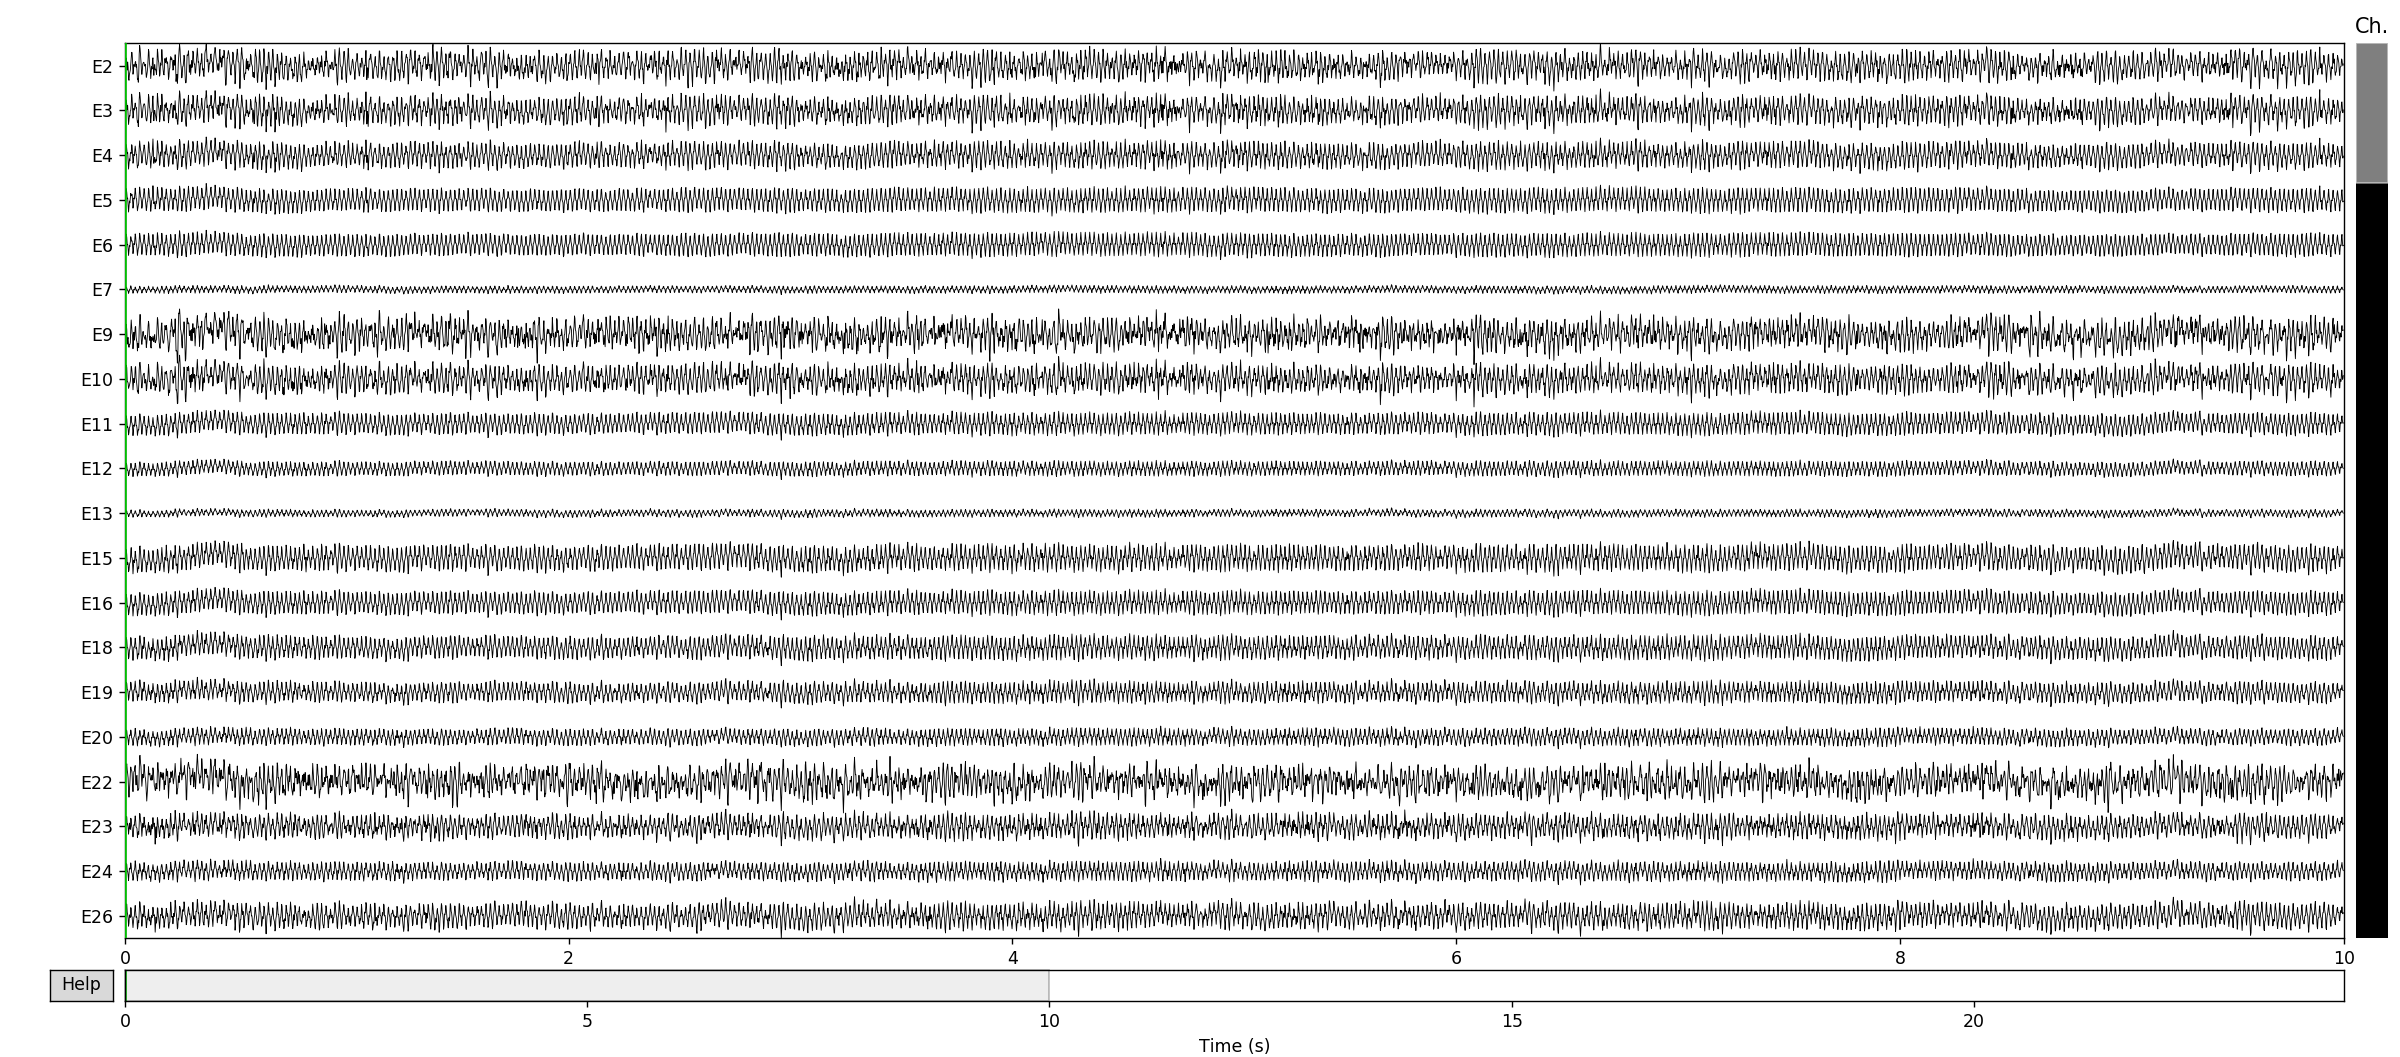

<IPython.core.display.Javascript object>


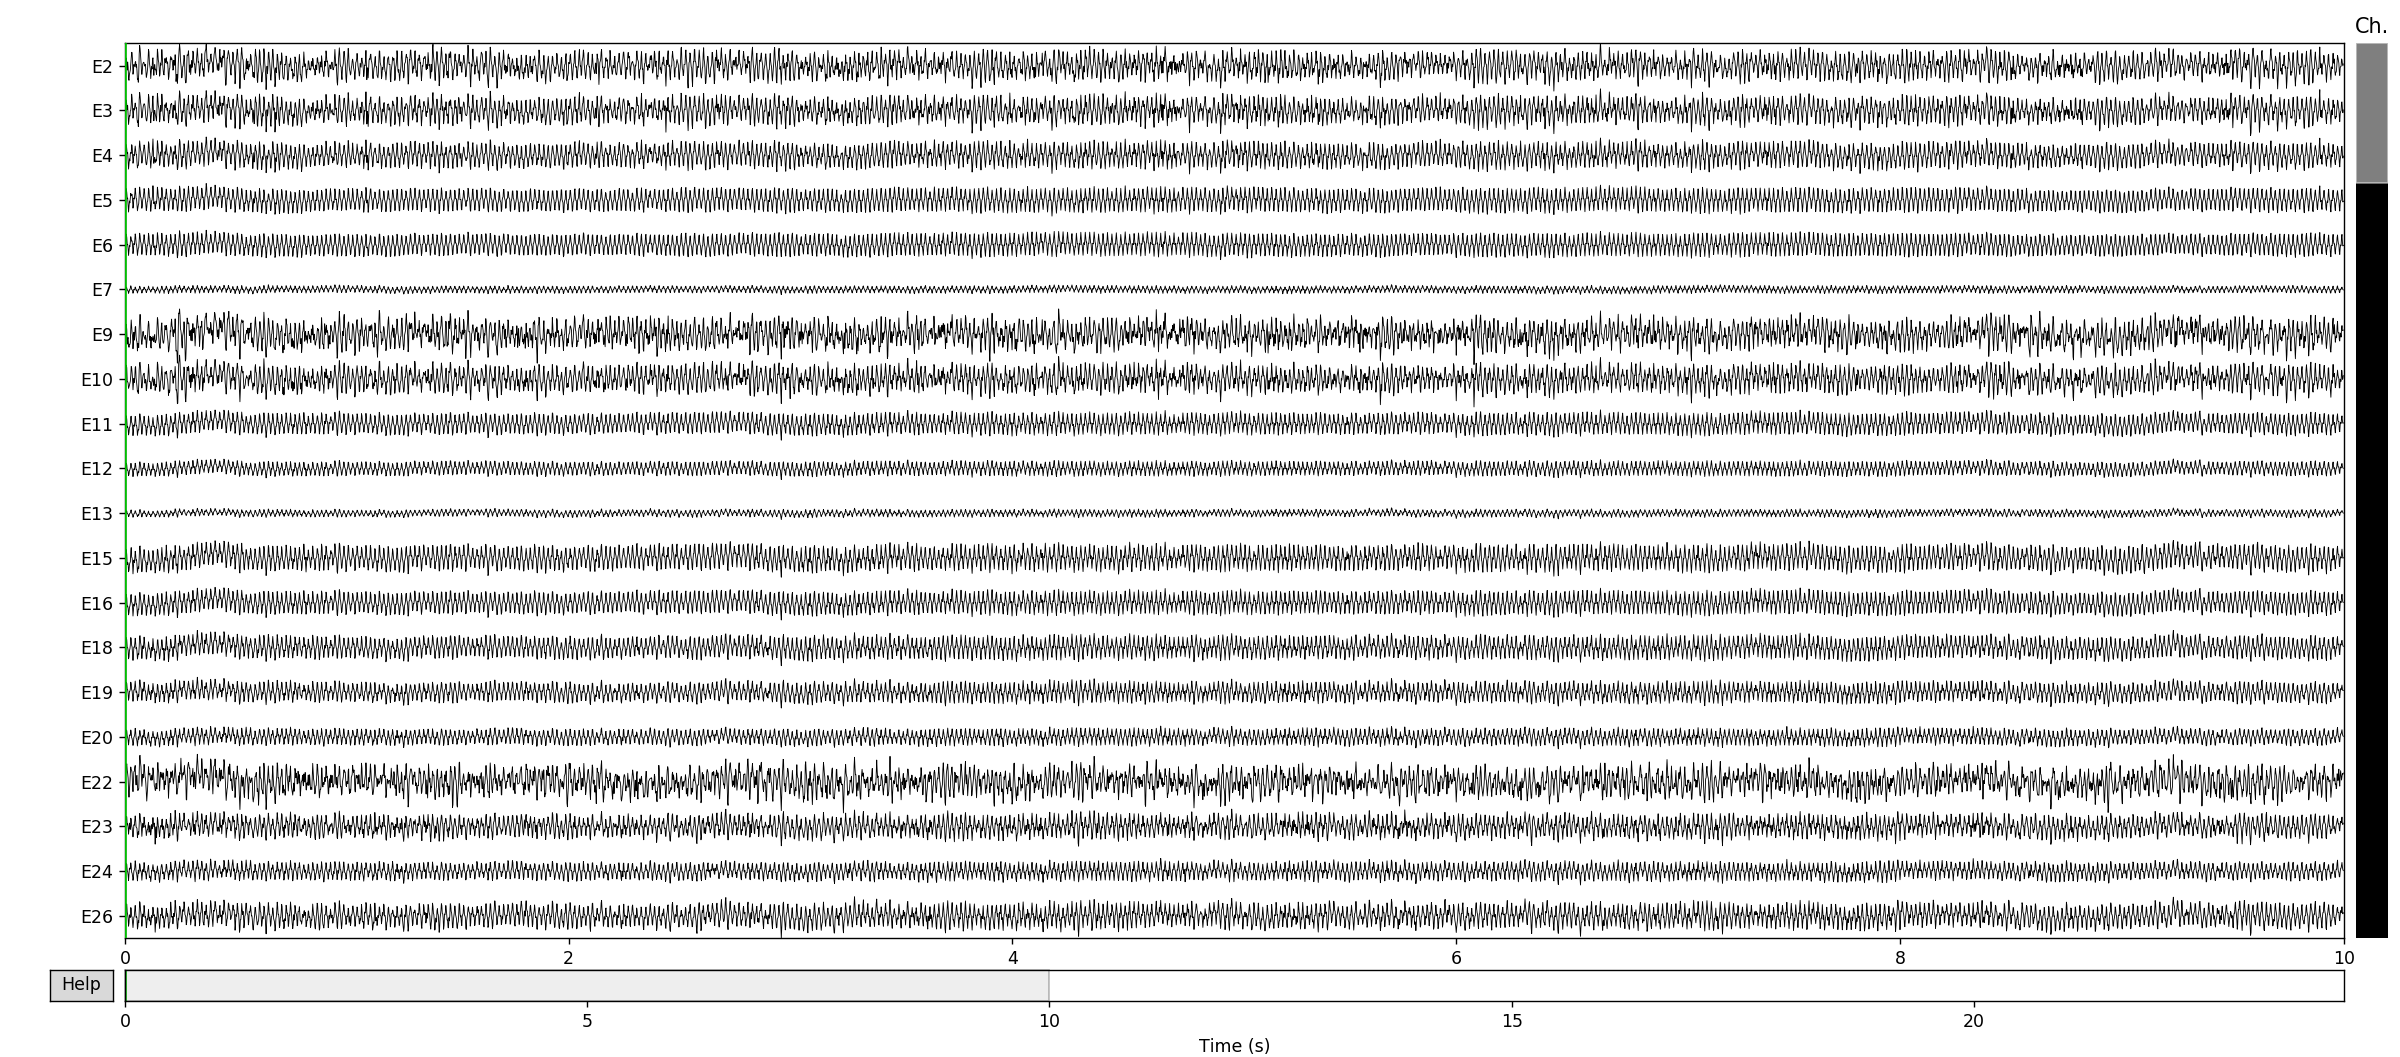

In [1]:
%pylab nbagg
import mne
import scipy.io as sio

from noisy import Noisydata
from reference import robust_reference, remove_reference
from utilities import union, set_diff
from removeTrend import removeTrend
from find_noisy_channels import NoisyChannels

mne.set_log_level("WARNING")


class MatReader:
    """
    Object to read mat files into a nested dictionary if need be.
    Helps keep strucutre from matlab similar to what is used in python.
    """
    def __init__(self, filename=None):
        self.filename = filename
    def loadmat(self, filename):
        """
        this function should be called instead of direct spio.loadmat
        as it cures the problem of not properly recovering python dictionaries
        from mat files. It calls the function check keys to cure all entries
        which are still mat-objects
        """
        data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        return self._check_keys(data)
    def _check_keys(self, dict):
        """
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in dict:
            if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
                dict[key] = self._todict(dict[key])
        return dict
    def _todict(self, matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        dict = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                dict[strg] = self._todict(elem)
            elif isinstance(elem, np.ndarray):
                dict[strg] = self._tolist(elem)
            else:
                dict[strg] = elem
        return dict
    def _tolist(self, ndarray):
        """
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mio5_params.mat_struct):
                elem_list.append(self._todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(self._tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list


raw = mne.io.read_raw_edf("D:/JHU/NDD/Motor Imagery Data/S003R01.edf", preload=True)
raw.rename_channels(lambda s: s.strip("."))
# raw = mne.io.read_raw_eeglab('D:/JHU/NDD/eeglab-master/sample_data/eeglab_data.set',
#                              eog='auto', preload=True)
reader = MatReader()
raw_mat = reader.loadmat('D:/JHU/NDD/ValidationEEGData/A86/A86goodEEGAll.mat')
raw_data = np.asarray(raw_mat['EEG']['data'])*1e-6
sfreq = raw_mat['EEG']['srate']
ch_info = raw_mat['EEG']['chanlocs']
ch_names = [ch_info[i]['labels'] for i in range(0, len(ch_info))]
ch_types = ['eeg' for chn in ch_names]
for i in [1, 8, 14, 17, 21, 25, 32, 125, 126, 127, 128]:
    ch_types[i-1] = 'eog'

n_chans = len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(raw_data, info)

eeg_index = mne.pick_types(raw.info, eeg=True, eog=False, meg=False)
eog_index = mne.pick_types(raw.info, eeg=False, eog=True, meg=False)
# Set montage
# montage_kind = "standard_1020"
montage_kind = "GSN-HydroCel-129"
# montage_kind = 'D:/JHU/NDD/eeglab-master/sample_data/eeglab_chan32.locs'
montage = mne.channels.read_montage(montage_kind, ch_names=raw.info['ch_names'])
raw.set_montage(montage)
raw.plot(bad_color='r', scalings=dict(eeg=5e-5))

In [2]:
montage.pos

array([[ 5.78767764,  5.52086322, -2.57746864],
       [ 5.29180473,  6.70909756,  0.3074349 ],
       [ 3.86412245,  7.63424051,  3.06777014],
       [ 2.86883756,  7.14570855,  4.98956456],
       [ 1.47934045,  5.68662139,  6.81287819],
       [ 0.        ,  3.80677022,  7.89130496],
       [-1.22380025,  1.55886443,  8.44043914],
       [ 4.2219015 ,  7.99881739, -1.35478968],
       [ 2.69540556,  8.88482032,  1.08830814],
       [ 1.83088234,  8.70883913,  3.18709115],
       [ 0.        ,  7.96264703,  5.044718  ],
       [-1.47934045,  5.68662139,  6.81287819],
       [-2.43587076,  3.25430722,  7.60876621],
       [ 1.27044766,  9.47901633, -0.94718331],
       [ 0.        ,  9.08744089,  1.33334501],
       [ 0.        ,  9.0764908 ,  3.10543847],
       [ 0.        ,  9.2711397 , -2.21151643],
       [-1.83088234,  8.70883913,  3.18709115],
       [-2.86883756,  7.14570855,  4.98956456],
       [-3.82579711,  5.121649  ,  5.94284488],
       [-1.27044766,  9.47901633, -0.947